# Shakespeare Text Generator
## 1. Recurrent Neural Network with LSTM Design:


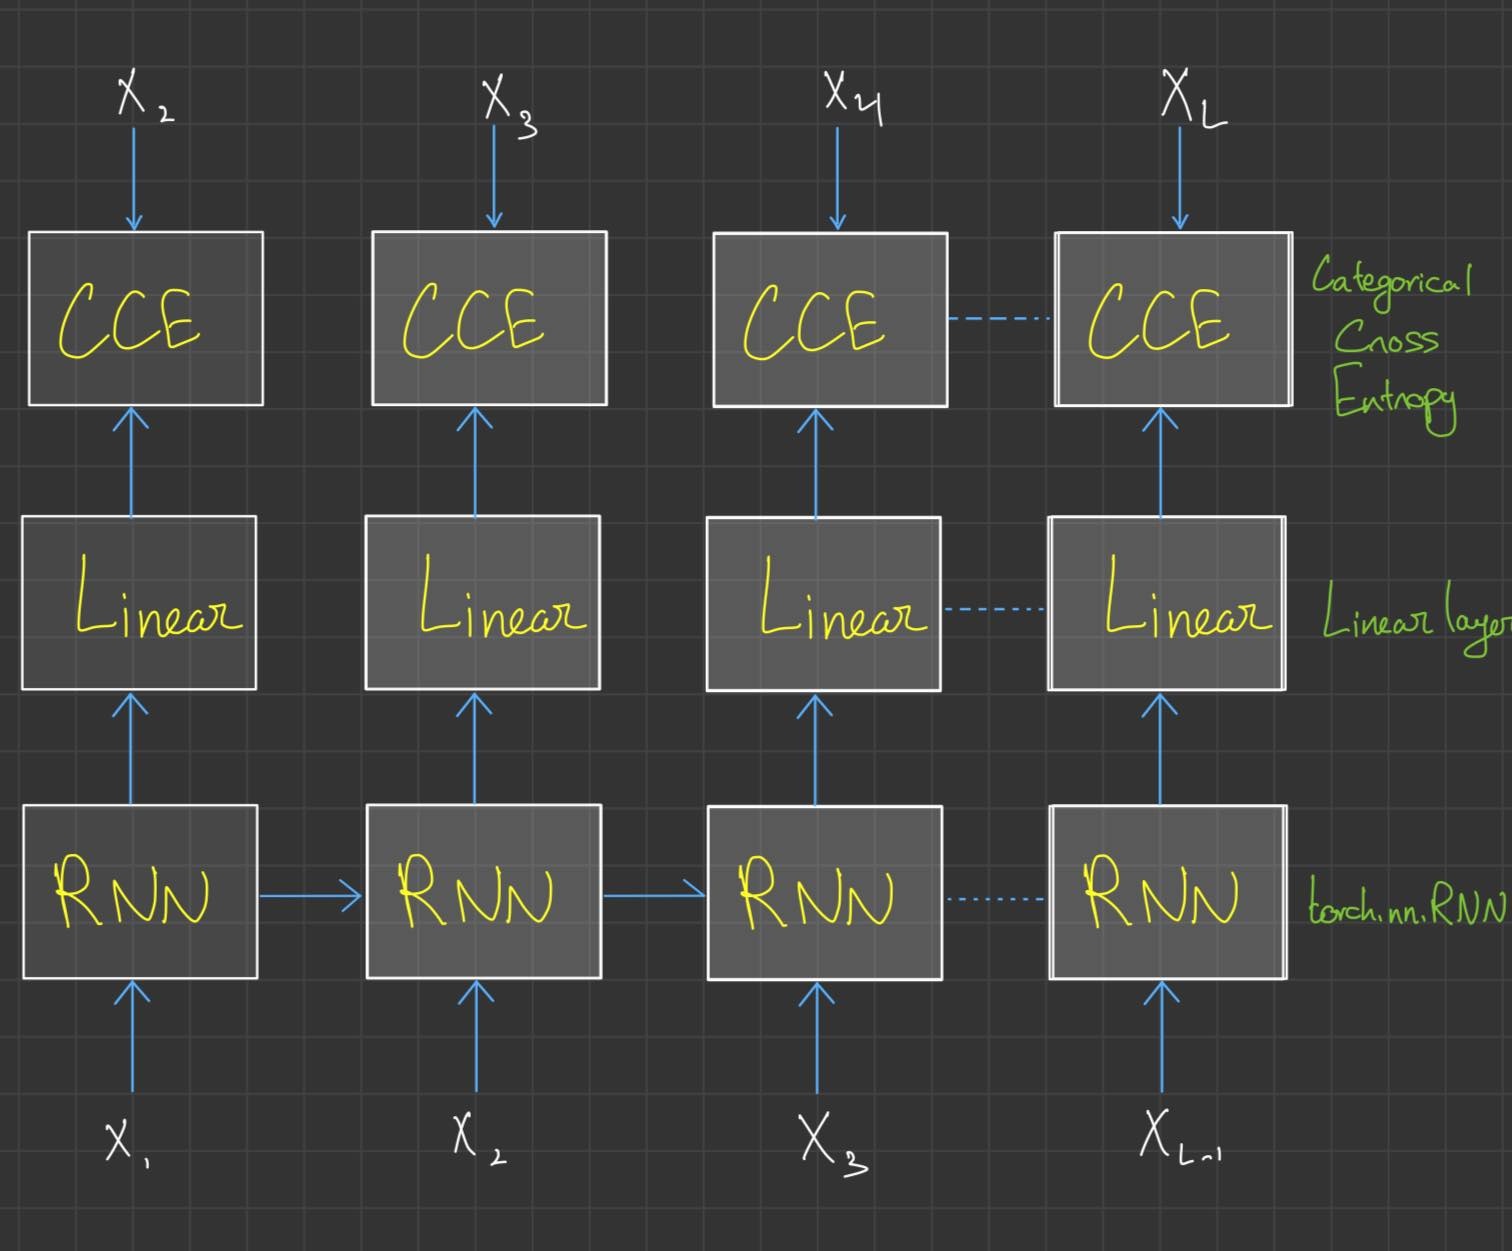

## 2. Download Shakespeare Dataset
---
consists of 6270 strings for training and 2790 strings for testing.

Each String is 100 Characters



In [1]:
# Download data from google drive repo:
!gdown --id 13WzBACCBG58H4xGzP_mGdpmmtvDUppZZ # Train data
!gdown --id 1G_VaOgs_eYs9vfkFVf0sJ1ELanq5zEuO  # Test data

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=13WzBACCBG58H4xGzP_mGdpmmtvDUppZZ
To: /content/trainset.pkl
100% 689k/689k [00:00<00:00, 104MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1G_VaOgs_eYs9vfkFVf0sJ1ELanq5zEuO
To: /content/testset.pkl
100% 306k/306k [00:00<00:00, 80.8MB/s]


## Needed Libraries:


In [2]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [3]:
import torch

## 3. Data Preparation
load training and testing datasets into .pkl files


In [4]:
import pickle

with open('trainset.pkl', 'rb') as f_train:
    train_data = pickle.load(f_train)

with open('testset.pkl', 'rb') as f_test:
    test_data = pickle.load(f_test)

print(train_data[0]) #testing folder


 him? My cousin Juliet?

LUCIO:
Is she your cousin?

ISABELLA:
Adoptedly; as school-maids change the


In [5]:
#joining all the training data into a single big string.
char_set = sorted(list(set(''.join(train_data))))
print(char_set)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
#Mapping Dataset into numbers to feed it to the RNN
def from_chars_to_indexes(data, char_set):
    """This function converts all the strings available in the data list into
    a tensor of indexes. The conversion between char and index is done based on
    the content of the char_set.

    Arguments
    ---------
    data : List
        A list containing strings to convert.

    char_set : List
        A list containing the set of characters. The first element corresponds to
        index 0, the second to index 1, and so on.

    Returns
    ---------
    data_index: torch.Tensor
        Tensor (N,L) containing the indexes corresponding to the input chars. N is
        the number of text chunks and L is the number of char in each chunk.
    """
    data_index = []
    for sequence in data:
        sequence_index = [char_set.index(char) for char in sequence]
        data_index.append(sequence_index)
    return torch.tensor(data_index)


# Convert the train and test data
train_data = from_chars_to_indexes(train_data, char_set)
test_data = from_chars_to_indexes(test_data, char_set)

## Converting dataset into PyTorch data loader object.


In [7]:
batch_size = 128
tr_dataset = torch.utils.data.TensorDataset(train_data)
tr_loader = torch.utils.data.DataLoader(tr_dataset, batch_size=batch_size, shuffle=True)

# 3.Main Model

number of layers: 1.

Neuron Dropout for better Model robustness: 0.1

In [8]:
class charRNN(torch.nn.Module):
  def __init__(self, char_set_size=10, embedding_dim=75, hidden_size=8, num_layers=1, dropout=0.1):
    super(charRNN, self).__init__()
    self.embedder = torch.nn.Embedding(char_set_size, embedding_dim)
    self.rnn = torch.nn.LSTM(input_size=embedding_dim,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             batch_first=True,
                             dropout=dropout)
    self.linear = torch.nn.Linear(in_features=hidden_size,
                                  out_features=char_set_size)

  def forward(self, X, h_0=None):
    """This function processes the input sequence X from the last
    element to the first one using an RNN.
    On top of each hidden state, a linear transformation
    that returns a scalar prediction for each time step is applied.

    Arguments
    ---------
    X : torch.Tensor
      Tensor containing the sequence of char (N, L).
    h_0 : torch.Tensor
      Initial hidden state. By default is None. This means that it will be
      internally initialized to zero when instantiating the torch.nn.LSTM object.

    Returns
    ---------
    out: torch.Tensor
      Tensor (N,L,char_set_size) containing the output at each time step.
    h_n: torch.Tensor
      Last hidden state.
    """
    # Run the RNN encoder
    embeddings = self.embedder(X)
    H, h_n = self.rnn(embeddings, h_0)
    out = self.linear(H)
    return out, h_n

# 4. Training:

- Loss/Objective function used: Categorical Cross Entropy
- epochs: 100
-learning rate: 0.001
- number of layers: 2
- dropout: 0.5

-Note to the reader: training this model takes long some time on the CPU. It only takes 7-8 minutes using the GPU. To use the GPU, go to `Runtime`=>`Change runtime type` and choose `GPU` as hardware accelerator". Note that this will **change the computing node** (and it will cancel all the previous output). If that happens, you just have to run the previous steps (the code won't be deleted of course).


In [9]:
# Hyperparameters
num_epoch = 100
lr = 0.001
hidden_size = 256
num_layers= 2
embedding_dim = 75
dropout = 0.5
device = 'cuda:0' # use 'cuda:0' to speed it up.


# Initialization
rnn = charRNN(char_set_size=len(char_set),
              embedding_dim=embedding_dim,
              hidden_size=hidden_size,
              num_layers=num_layers,
              dropout=dropout)
rnn.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

def training_loop(X, model, loss, optimizer, num_epoch=500, batch_size=100, device='cpu'):

  # Training Loop
  for epoch in range(num_epoch):

    for i, X in enumerate(tr_loader):

      # Input/Labels Manipulation
      X = X[0]
      y = torch.roll(X, -1, dims=1)
      X=X[:,:-1]
      y=y[:,:-1]
      X = X.to(device)
      y = y.to(device)

      # Run the RNN
      out, hn = model(X)
      # Out dim:  torch.Size([128, 99, 65])
      out = out.transpose(1,2)
      # Compute the loss
      l = loss(out,y)
      # Update the parameters
      optimizer.zero_grad()
      l.backward()
      optimizer.step()


    # Print loss
    if (epoch + 1) % 10 == 0:
        print("Epoch %03d: Train_loss: %.4f " %(epoch+1, l.item()))

# Run the training loop
training_loop(train_data , rnn, loss, optimizer, num_epoch, batch_size, device)

Epoch 010: Train_loss: 1.7458 
Epoch 020: Train_loss: 1.5519 
Epoch 030: Train_loss: 1.4815 
Epoch 040: Train_loss: 1.3765 
Epoch 050: Train_loss: 1.3569 
Epoch 060: Train_loss: 1.3232 
Epoch 070: Train_loss: 1.3183 
Epoch 080: Train_loss: 1.2428 
Epoch 090: Train_loss: 1.2694 
Epoch 100: Train_loss: 1.2421 


## Testing performance on test set:

In [10]:
# Switch RNN to eval modality
rnn.eval()

# send data to device used
test_data = test_data.to(device)


# Running the charRNN on test data
out, _ = rnn(test_data)

# Derive test labels (left shift).
y_test = torch.roll(test_data, shifts=-1, dims=1)


# Remove last time step in out and y_test
out = out[:, :-1]
out = out.transpose(1,2)
y_test = y_test[:, :-1]


# Compute the loss
loss_test = loss(out, y_test)

# Print the test loss
print("Test_loss: %.4f " %(loss_test.item()))

Test_loss: 1.4273 


# 5. Text Generation

- please change "L" in the last line of code to increase or decrease the length of the generated text

In [11]:
def generate(rnn, L=100):
  """This function generates text of length L characters using the RNN model
  in input

  Arguments
  ---------
  rnn : charRNN object
    Pretrained RNN model used to generate text.
  L : int
    Length of the text to generate.

  Returns
  ---------
  output_text: string
    String containing the generated text.
  """

  # feeding a random input for ease of use -- can be changed to prompt the user too
  current_input = torch.randint(len(char_set), (1,1), device=device)

  #Initialization of vars
  output_text = ''
  h_in = None

  # Loop over time dimension
  for i in range(L):
    # Feed RNN and get output and new hidden state
    out, h_in = rnn(current_input, h_in)

    # Compute probabilities from the output
    probs = torch.nn.functional.softmax(out.squeeze(0), dim=-1)

    # Sample the current output from the probabilities
    current_output = torch.multinomial(probs, num_samples=1)

    # Add current output to output text
    output_text += char_set[current_output.item()]

    # Update input to be used for next iteration
    current_input = current_output

  return output_text


# Set the model to evaluation mode
rnn.eval()
text = generate(rnn, L=600) # You can change L  here to generate shorter of bigger texts
print(text)


 death to prison.
Secuny this still and spur upne doubt!
I am not-speed his knave:
The king of heaven of live: where you
should noble holy wrong; for he is reserved hold widinunes.
What say it full, What's for this?
Greated plints upon you.

PETRUCHIO:
'Tis a strength to yield.

First Lord:
No house obed, and wonder'd words, and takes my man,
For there is no lord; he comjeys sweet a
place of time and dull of tyearers peace.
You were and too speak; the Ratchmonanly dispossession
That is a bawl'd--
As words that nosure it should be their;
Within the was on conscience shall have
no sense are much


# THANK YOU
